In [ ]:
!pip install pyEDM 
!pip install torchcde
!pip install gdown  # чтобы скачать данные с гугл диска

from IPython.display import clear_output
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy.random as npr
import pandas as pd
import pyEDM   # реализация CCM
import torchdiffeq
import os
import sys
from importlib import reload 
from google.colab import drive
import torch
import warnings

# drive.mount('/content/drive')
# подключение к папкам
# os.chdir("drive/MyDrive/Colab Notebooks/m1p")
# sys.path.insert(0, os.getcwd())

# потому что при обработке появляются разреженные таблицы
warnings.filterwarnings("ignore")
clear_output()

# Новый раздел

In [ ]:
from numpy.lib.shape_base import column_stack
import code_folder.accelerometer_gyroscope_data_prepare as data
import code_folder.train as train
import code_folder.ODE_on_RNN as ode_on_rnn
import code_folder.ODE_RNN as ode_rnn
import code_folder.Modules as nets

data = reload(data)
def train_axis(axis, embedding_dim, filenames, net, epochs = 20, optim = None, timescale = 1., random = False):
    def epoch_dataset(dataset, epochs):
        for i in range(epochs):
            yield dataset
    if random:
        train_data, test_data = data.make_random_dataset(len(axis), embedding_dim)
    else:
        train_data, test_data = data.make_datasets(axis, *filenames, embedding_dim, timescale = timescale)
    train_dataset = epoch_dataset(train_data, epochs)
    test_dataset  = epoch_dataset(test_data, epochs)
    optim = torch.optim.Adam(net.parameters(), lr = 0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=13, gamma=0.8)
    net = train.train_with_epoch(net, train_dataset, test_dataset, epochs, optim = optim)
    return net, train_data, test_data

def train_on_dataset(train_dataset, test_dataset, net, epochs = 20, optim = None, timescale = 1., random = False):
    def epoch_dataset(dataset, epochs):
        for i in range(epochs):
            yield dataset
    train_dataset = epoch_dataset(train_dataset, epochs)
    test_dataset  = epoch_dataset(test_dataset, epochs)
    optim = torch.optim.Adam(net.parameters(), lr = 0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=13, gamma=0.8)
    net = train.train_with_epoch(net, train_dataset, test_dataset, epochs, optim = optim)
    return net, train_dataset, test_dataset

def get_hidden(net, dataset):
    # print(train_data[0][0].shape)
    h_s = []
    net = net.cpu()
    for X, y , t in dataset:
        X = X.float()
        t = t.float()
        val, hid, _ = net(X, t, return_hidden = True)
        h_s.append(hid[-1])  # скрытое состояние последнего в эмбеддинге
    h_s = np.array(torch.hstack([i[0].detach() for i in h_s]))
    return h_s

def get_hidden_long(net, axis, filenames,):
    dataset = data.DataPreprocess(*filenames).align_by_time().normalize(axis)
    time = torch.tensor(np.array(dataset.data.iloc[1:, 0]) - np.array(dataset.data.iloc[: - 1, 0])).reshape(1, 1, -1).float()
    X = torch.tensor(np.array(dataset.data[axis].iloc[1:])).T.unsqueeze(0).float()
    _, h_s, _ = net(X, time, return_hidden = True)
    h_s = np.array(torch.hstack([i[0].detach() for i in h_s]))
    return h_s

def apply_CCM(d_s_1, d_s_2, time, to, d_s_1_columns, d_s_2_columns, libSizes = None):
    if libSizes is None: libSizes = "10 120 5"
    d_s_1 = d_s_1[:to]
    d_s_2 = d_s_2[:to]
    time = time[:to]

    data_ = pd.DataFrame(np.hstack([time.squeeze()[..., None], d_s_1, d_s_2]),
            columns = ['time', *d_s_1_columns, *d_s_2_columns])
    tmp = pyEDM.CCM(dataFrame = data_, 
                    columns = d_s_1_columns, target = d_s_2_columns,
                    embedded = True, libSizes= libSizes, 
                    sample = 10, showPlot = True)

def apply_CCM_on_dataset(dataset, to, d_s_1_columns, d_s_2_columns, libSizes = None):
    if libSizes is None: libSizes = "10 120 5"
    data_ =dataset.iloc[:to]
    tmp = pyEDM.CCM(dataFrame = data_, 
                    columns = d_s_1_columns, target = d_s_2_columns,
                    embedded = True, libSizes= libSizes, 
                    sample = 10, showPlot = True)
    
embedding_dim = 20
filenames = ["./unzipped/5/Accelerometer.csv","./unzipped/5/Gyroscope.csv"]
gyroscope_axis = ["G:x", "G:y", "G:z"]
gyroscope_embedding_dim = 100

accelerometer_axis = ["A:x", "A:y", "A:z"]
accelerometer_embedding_dim = 10

gyroscope_data_dim = 3
gyroscope_embedding_dim = 10
len_ = 2837
all_data = data.DataPreprocess(*filenames).preprocess(embedding_dim, gyroscope_axis + accelerometer_axis)
# accelerometer_train, accelerometer_test = data.make_datasets(accelerometer_axis, *filenames, accelerometer_embedding_dim, shuffle = False)
# gyroscope_train, gyroscope_test         = data.make_datasets(gyroscope_axis, *filenames, gyroscope_embedding_dim, shuffle = False)
random_train, random_test, random_dataset = data.make_random_dataset(gyroscope_data_dim, embedding_dim, len_, shuffle = False)
# 

inited


In [ ]:
def train_on_pair(datasets_1, datasets_2, net_1, net_2, epochs = 10):
# datasets_i = (train, test)
    train_on_dataset(*datasets_1, net_1, epochs, )
    train_on_dataset(*datasets_2, net_2, epochs, )
    return net_1, net_2

Просто CCM

# walking hidden


In [ ]:
!ls ./data/gyroscops_2

left  right


In [ ]:
names = []
for dirpath, dirnames, filenames in os.walk("./data/gyroscops_2"):
    for name in filenames:
        print(dirpath + '/'+ name)
        names.append(dirpath + '/'+ name)

./data/gyroscops_2/left/walk_50.zip
./data/gyroscops_2/left/walk_200.zip
./data/gyroscops_2/left/run_200_1.zip
./data/gyroscops_2/left/run_200_2.zip
./data/gyroscops_2/left/walk_50/GyroscopeUncalibrated.csv
./data/gyroscops_2/left/walk_50/Metadata.csv
./data/gyroscops_2/left/walk_50/Annotation.csv
./data/gyroscops_2/left/walk_50/Accelerometer.csv
./data/gyroscops_2/left/walk_50/AccelerometerUncalibrated.csv
./data/gyroscops_2/left/walk_50/TotalAcceleration.csv
./data/gyroscops_2/left/walk_50/Gyroscope.csv
./data/gyroscops_2/left/walk_200/Metadata.csv
./data/gyroscops_2/left/walk_200/TotalAcceleration.csv
./data/gyroscops_2/left/walk_200/AccelerometerUncalibrated.csv
./data/gyroscops_2/left/walk_200/Annotation.csv
./data/gyroscops_2/left/walk_200/GyroscopeUncalibrated.csv
./data/gyroscops_2/left/walk_200/Accelerometer.csv
./data/gyroscops_2/left/walk_200/Orientation.csv
./data/gyroscops_2/left/walk_200/Gyroscope.csv
./data/gyroscops_2/left/run_200_2/AccelerometerUncalibrated.csv
./data/

In [ ]:
PATH = "./data/gyroscops_2/"
name = "run_200_2/Gyroscope.csv"
left = pd.read_csv(PATH + "left/" + name, delimiter=',', decimal = '.', dtype="float")
right = pd.read_csv(PATH + "right/" + name,  delimiter=',',  decimal = '.', dtype = "float")

# left = left.drop(columns=["time"])
# right = right.drop(columns=["time"])
# непонятно откуда взявшиеся колонки
left = left.drop(columns=["Unnamed: 0"])
right = right.drop(columns=["Unnamed: 0"])

SVD

чтобы увидеть наглядно как работает CCM

In [ ]:
from sklearn.preprocessing import normalize

def get_svd(array):
    dim = 3 
    tmp = np.array(array.x.values)[700: 2500]
    tmp = np.vstack([tmp[i: i + 300] for i in range(tmp.shape[0] - 300)])
    P, D, Q = np.linalg.svd(tmp)
    print(P.shape, D.shape, Q.shape)
    hid = P[:, : dim] @ np.diag(D[:dim])
    # val = P[:, : dim] @ np.diag(D[:dim]) @ Q[:dim]
    return hid  

def stats(array, step):
    means = np.zeros((step, array.shape[1]))
    disps = np.zeros((step, array.shape[1]))
    array = normalize(array, axis = 1)
    for i in range(step):
        neigh = np.array(sorted(array, key = lambda x: np.linalg.norm(array[i] - x)))[:20]
        mean = np.mean(neigh, axis = 0)
        # # print(mean.shape, neigh.shape)
        # print((neigh - mean) ** 2)
        disp = np.mean((neigh - mean) ** 2, axis = 0)
        means[i] = mean
        disps[i] = disp
    return means, disps

def stats_periodic(array, step):
    means = np.zeros((step, array.shape[1]))
    disps = np.zeros((step, array.shape[1]))
    for i in range(step):
        dots = []
        for j in range(i, len(array), step):
            dots.append(array[j])
        dots = np.vstack(dots)
        mean = np.mean(dots, axis = 0)
        disp = np.mean((dots- mean) ** 2, axis = 0)
        means[i] = mean
        disps[i] = disp
    return means, disps

def plots(arrays, markers, to = 1000, x = 40 , y=40):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for arr, mark in zip(arrays, markers):
        tmp = normalize(arr, axis = 1)
        if mark is None:
            ax.plot(tmp[:, 0][:to], tmp[:, 1][:to], tmp[:, 2][:to], label='parametric curve')
        else:
            ax.plot(tmp[:, 0][:to], tmp[:, 1][:to], tmp[:, 2][:to], mark)
    ax.view_init(x, y)


(1500, 1500) (300,) (300, 300)
(1500, 1500) (300,) (300, 300)


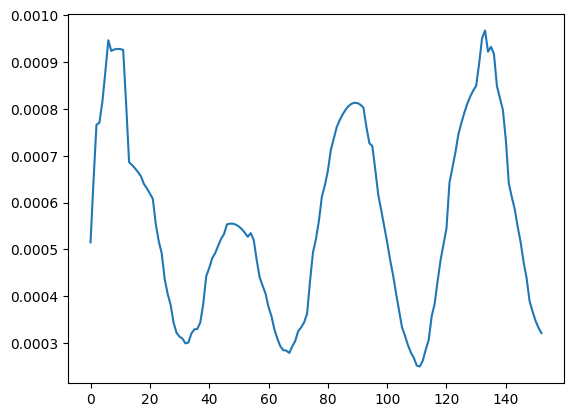

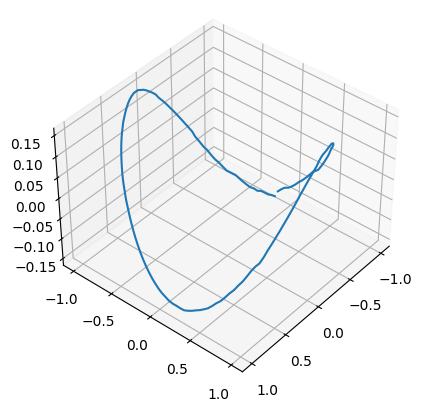

In [ ]:
left_h = get_svd(left)
right_h = get_svd(right)

right_mean, right_disp = stats(right_h, 153)
right_disp = np.mean(right_disp, axis = 1)  # переводим в двумерный


plt.plot(right_disp)
plots([right_mean], [None])
plt.show()

траектория зацикливается через 153 измерения

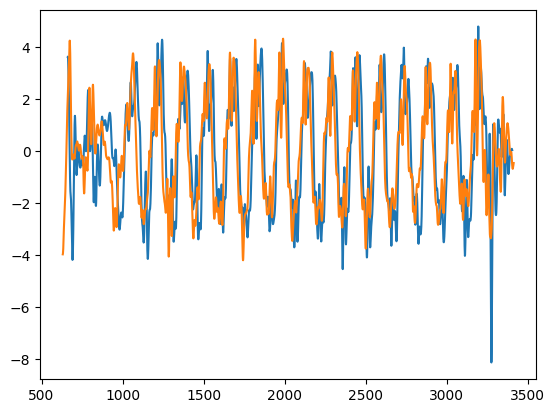

In [ ]:
plt.plot(left["x"][:])
plt.plot(-right["x"][:])

и найдем в каждом ряде момент для синхронизации - послений всплеск


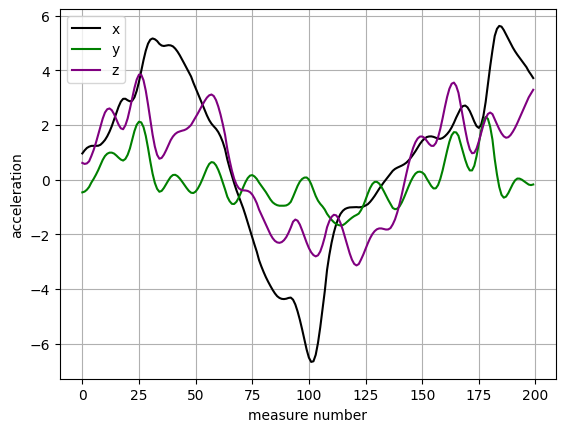

In [ ]:
to = 200
plt.plot(np.array(left)[..., 1][1500: 1700], label = 'x', color="black")
plt.plot(np.array(left)[..., 2][1500: 1700], label = 'y', color="green")
plt.plot(np.array(left)[..., 3][1500: 1700], label = 'z', color="purple")
plt.grid()
plt.xlabel('measure number')
plt.ylabel("acceleration")
plt.legend()
plt.show()

чтобы отрезать куски из начала движения

только в этом файле такие left и right

In [ ]:
left_index = 600 + np.argmax(np.array(left["x"][600: 700]))
# left_index
right_index = 600 + np.argmax(np.array(right["x"][600:700]))
# right_index

662

1579
в правом нужен верхний пик


In [ ]:
left['seconds_elapsed'] -= left['seconds_elapsed'][left_index]
right['seconds_elapsed'] -= right['seconds_elapsed'][right_index]

left = left.iloc[left_index:]
right = right.iloc[right_index:]

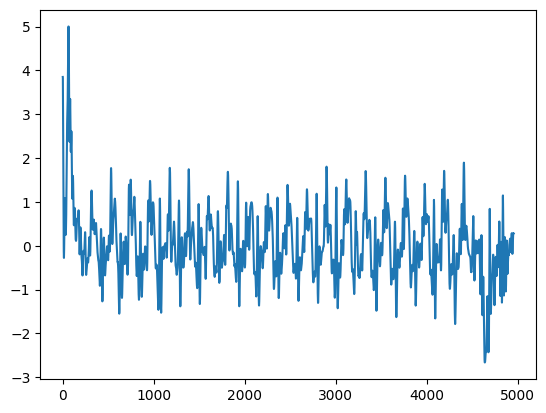

In [ ]:
plt.plot(np.array(left["y"][:]))

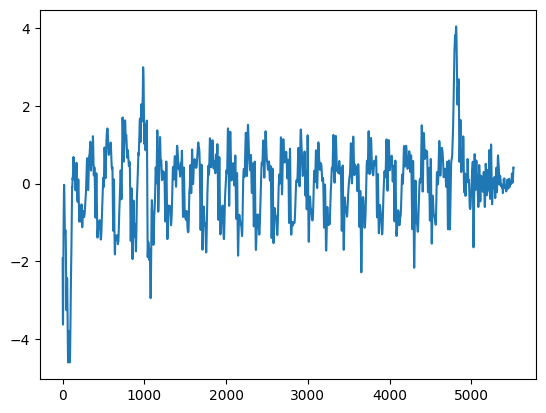

In [ ]:
plt.plot(np.array(right["y"][:]))

In [ ]:
right.columns = ["seconds_elapsed", 'x', 'y', 'z']
left.columns = ["seconds_elapsed", 'x', 'y', 'z'] 

In [ ]:
preprocessor = data.DataPreprocess(data = [])
preprocessor.acc_data = left
preprocessor.gyr_data = right

emb_dim = 25

data = reload(data)
preprocessor = preprocessor.align_by_time()
preprocessor.data = preprocessor.data.iloc[200:2500]
preprocessed = preprocessor.embed(emb_dim).embed_to_delta_t()

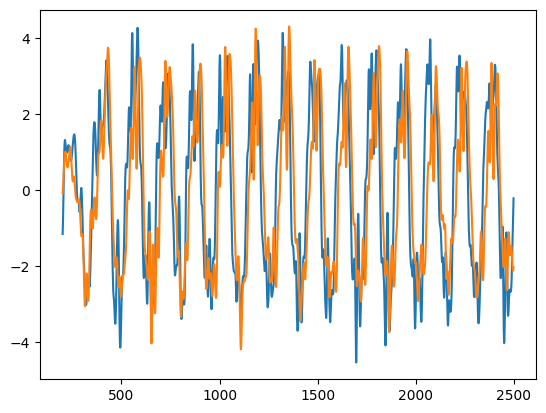

In [ ]:
plt.plot( preprocessor.data["A:z"])
plt.plot(-preprocessor.data["G:z"])

In [ ]:
def get_dataset(axis, shuffle = True):
    batch_size = 200
    tmp = data.Accessor.get_axis(preprocessed, axis)
    tmp = data.Accessor.train_test_split(*tmp, 0.75)
    train_ = tmp[0], tmp[2], tmp[4]
    test_ = tmp[1], tmp[3], tmp[5] 
    train_ = data.DatasetReady(*train_)
    test_ = data.DatasetReady(*test_)
    train_ = data.DataLoader(train_, batch_size, drop_last = True, shuffle = shuffle)
    test_ = data.DataLoader(test_, batch_size, drop_last = True, shuffle = shuffle)
    return train_, test_

можно указать по каким осям хотим обучать

In [ ]:
left_train, left_test = get_dataset(["G:x", "G:y", "G:z"])
right_train, right_test = get_dataset(["A:x", "A:y", "A:z"])

тренируем модели

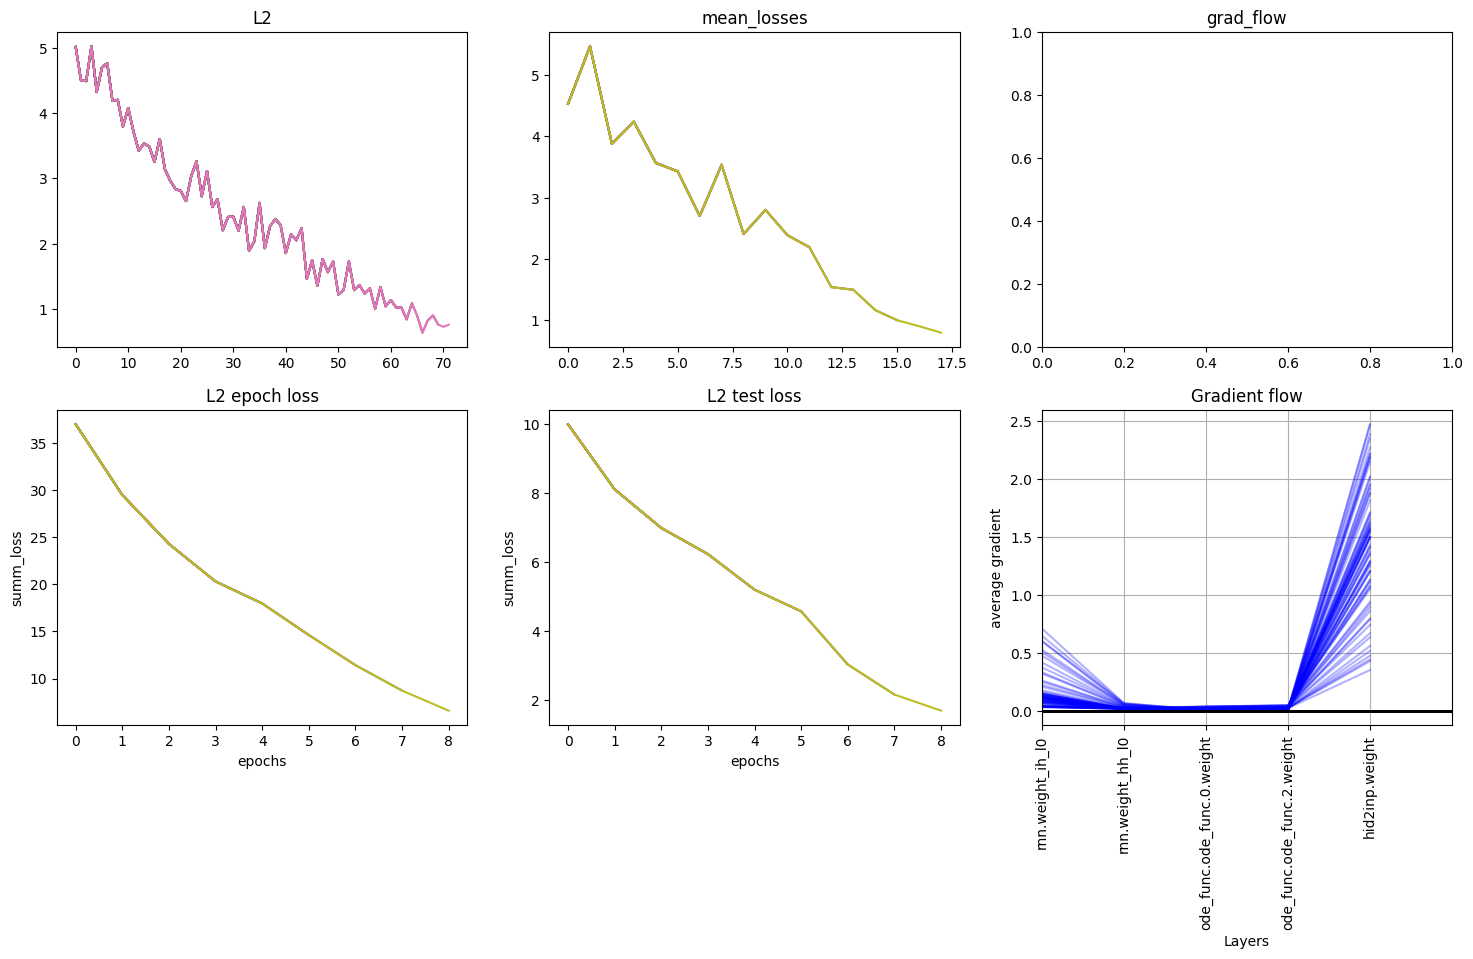

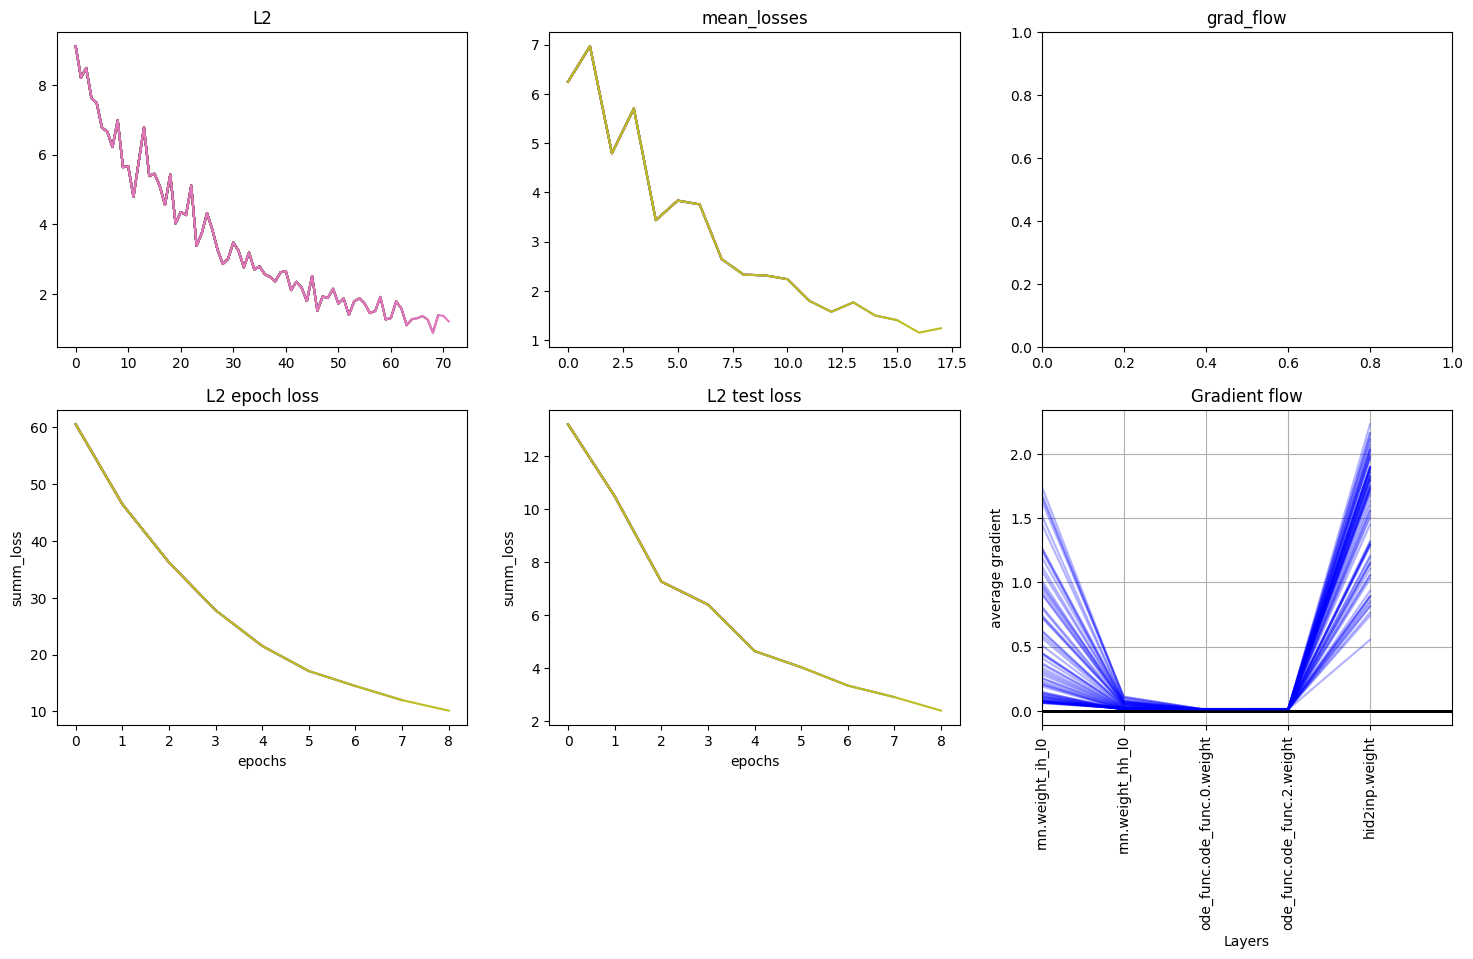

(ODE_RNN(
   (rnn): GRU(1, 3)
   (ode_func): ODE_func(
     (ode_func): Sequential(
       (0): Linear(in_features=3, out_features=3, bias=True)
       (1): ELU(alpha=1.0, inplace=True)
       (2): Linear(in_features=3, out_features=3, bias=True)
     )
   )
   (ode): NeuralODE(
     (func): ODE_func(
       (ode_func): Sequential(
         (0): Linear(in_features=3, out_features=3, bias=True)
         (1): ELU(alpha=1.0, inplace=True)
         (2): Linear(in_features=3, out_features=3, bias=True)
       )
     )
   )
   (hid2inp): Linear(in_features=3, out_features=1, bias=True)
   (loss_function): MSELoss()
 ),
 ODE_RNN(
   (rnn): GRU(1, 3)
   (ode_func): ODE_func(
     (ode_func): Sequential(
       (0): Linear(in_features=3, out_features=3, bias=True)
       (1): ELU(alpha=1.0, inplace=True)
       (2): Linear(in_features=3, out_features=3, bias=True)
     )
   )
   (ode): NeuralODE(
     (func): ODE_func(
       (ode_func): Sequential(
         (0): Linear(in_features=3, out_featu

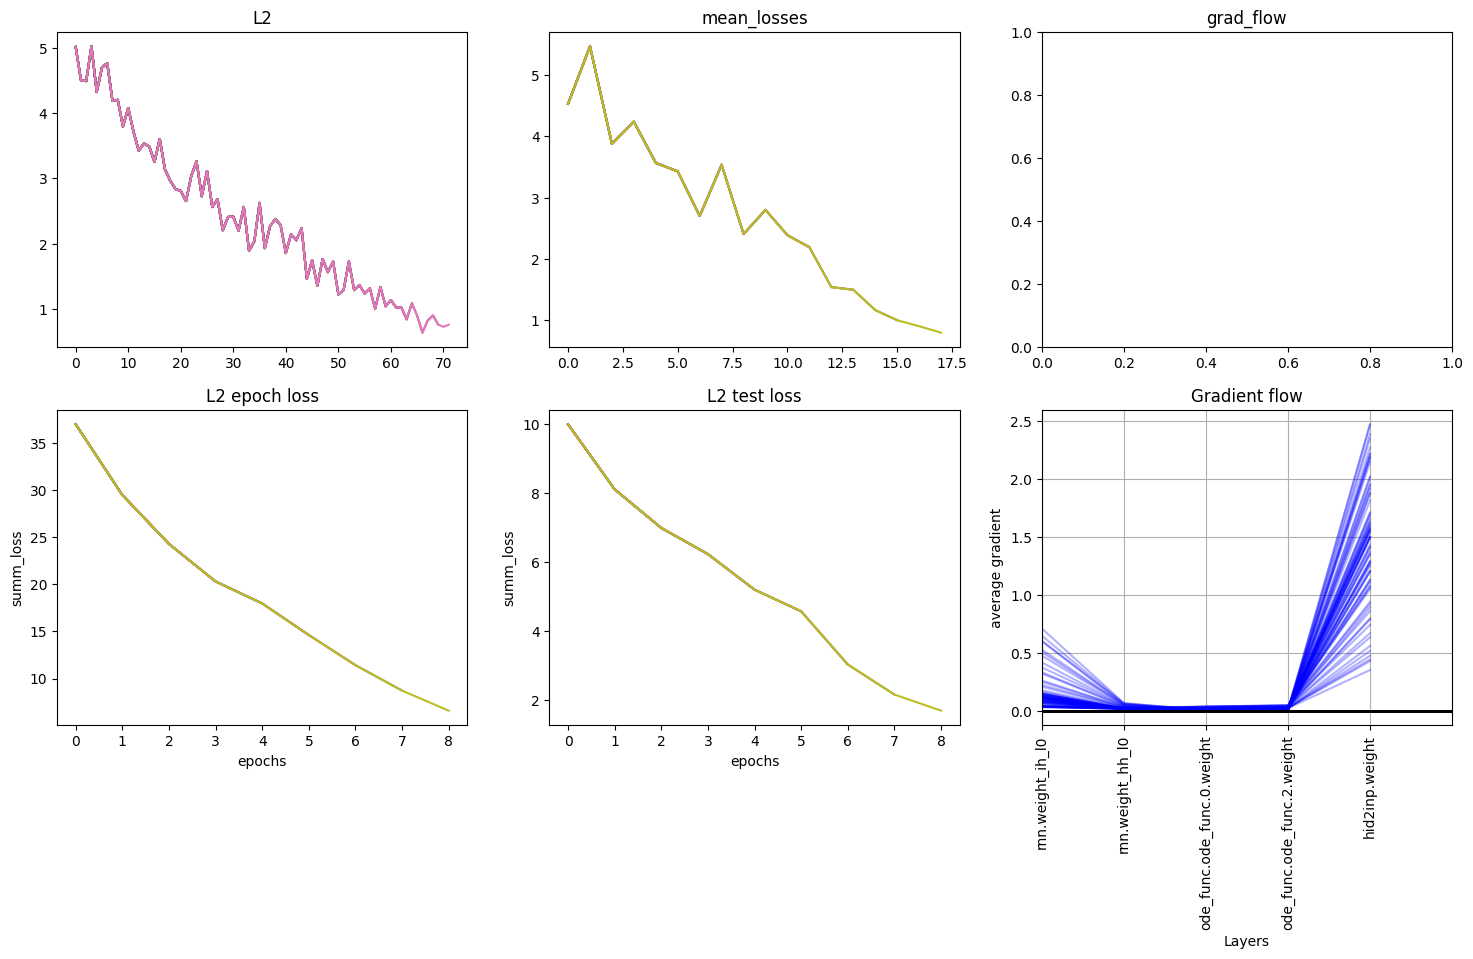

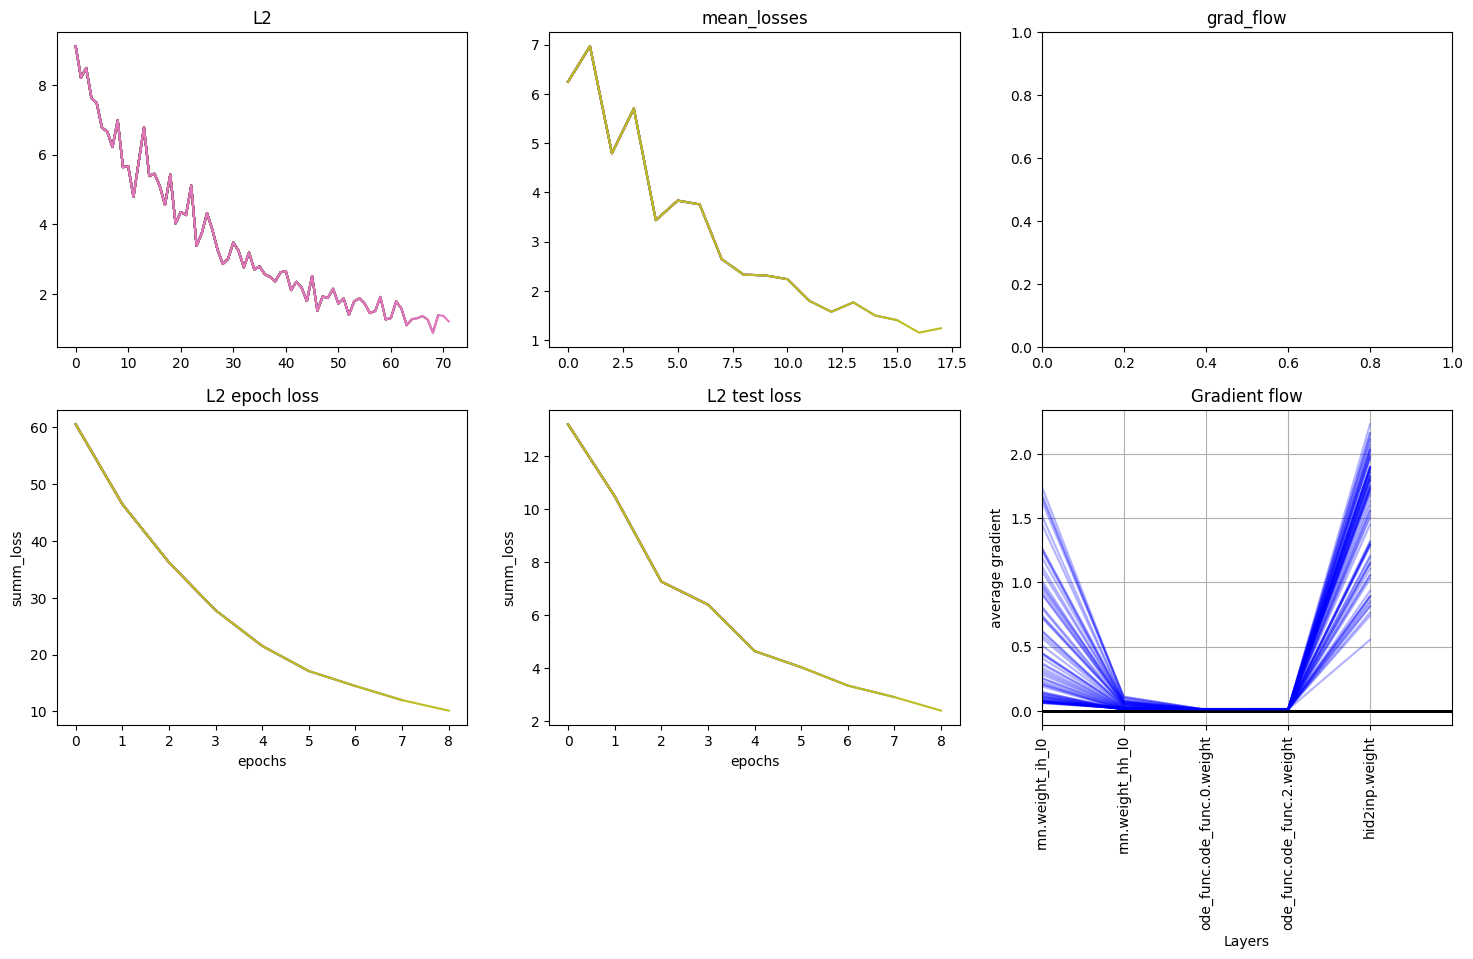

In [ ]:
# (axis, embedding_dim, filenames, net, epochs = 20, optim = None):
ode_rnn = reload(ode_rnn)
train = reload(train)
data = reload(data)
nets = reload(nets)

hidden_dim = 3
# emb_dim = 10
data_dim = 1
epochs = 9
left_net = nets.ODE_RNN(data_dim, hidden_dim)
# left_net.add_hooks()
right_net = nets.ODE_RNN( data_dim, hidden_dim)
# right_net.add_hooks()
_ = train_on_pair((left_train, left_test), (right_train, right_test), left_net, right_net, epochs)

In [ ]:
def get_hidden_long(net, axis):
    dataset = preprocessor
    time = torch.tensor(np.array(dataset.data.iloc[1:, 0]) - np.array(dataset.data.iloc[: - 1, 0])).reshape(1, 1, -1).float()
    X = torch.tensor(np.array(dataset.data[axis].iloc[1:])).T.unsqueeze(0).float()
    _, h_s, _ = net(X, time, return_hidden = True)
    h_s = np.array(torch.hstack([i[0].detach() for i in h_s]))
    return h_s

отображение корреляций скрытых слоев

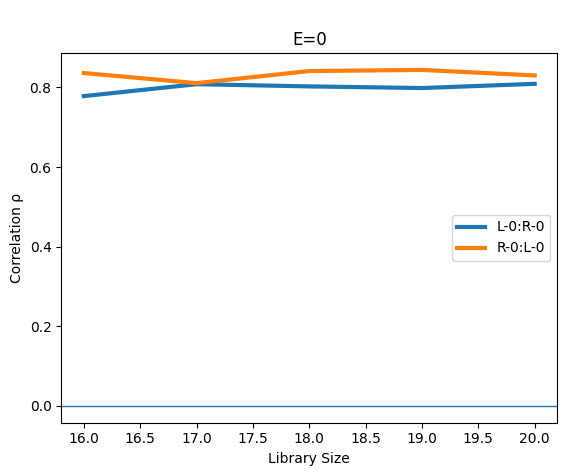

In [ ]:
# ode_rnn = reload(ode_rnn)
left_h_s  = get_hidden_long(  left_net , gyroscope_axis[:1],)[0]
right_h_s  = get_hidden_long( right_net , accelerometer_axis[:1])[0]
time = np.linspace(0, 1, 3000)
left_cols = [f"L-{i}" for i in range(left_h_s.shape[1])]
right_cols = [f"R-{i}" for i in range(right_h_s.shape[1])]
apply_CCM(left_h_s, right_h_s, time, 900, left_cols, right_cols, "16 20 1")


In [ ]:
# SSA - гусеница
def average_adiag(x):
    x1d = [np.mean(x[::-1, :].diagonal(i)) for i in
           range(-x.shape[0] + 1, x.shape[1])]
    return np.array(x1d)

def SSA(array, emb_len, num_groups, count_in_group = 3):
    # array is 1 dimentional select num_groups * count_in_group biggest singular values
    embedded = np.vstack([array[i :  i + emb_len] for i in range(array.shape[0] - emb_len) ])
    P, D, Q = np.linalg.svd(embedded)
    assert  num_groups * count_in_group  <= len(D)
    print(D[:10])
    groups = []
    for i in range(0, num_groups * count_in_group, count_in_group):
        tmp = (P[:, i: i + count_in_group] * D[i: i + count_in_group])
        # print(P.shape, D.shape, Q.shape, embedded.shape)
        # print(tmp.shape, Q[..., i: i + count_in_group].shape)
        tmp = tmp @ Q[i: i + count_in_group]
        # print(tmp.shape)
        tmp = average_adiag(tmp)
        # print(tmp.shape)
        # break
        groups.append(tmp)
    
    return groups

def apply_SSA(array, emb_len, count_in_group):
    # возвращает результат применения гусеницы отдельно к осям
    rez = []
    for i in range(array.shape[1]):
        tmp = SSA(array[..., i], emb_len, 1 , count_in_group)
        rez.append(tmp[0])
    return np.vstack(rez)

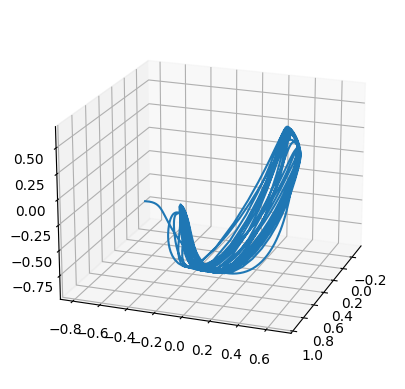

In [ ]:
# left_ssa = apply_SSA(left_h_s[..., :3], 153, 4)
plots([left_ssa.T], [None], 3000,  20, 20)

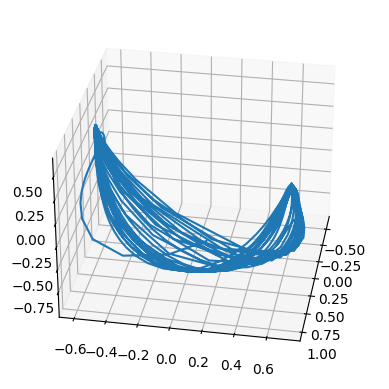

In [ ]:
# right_ssa = apply_SSA(right_h_s[..., :3], 153, 4)
plots([right_ssa.T], [None], 3000, 30, 10)

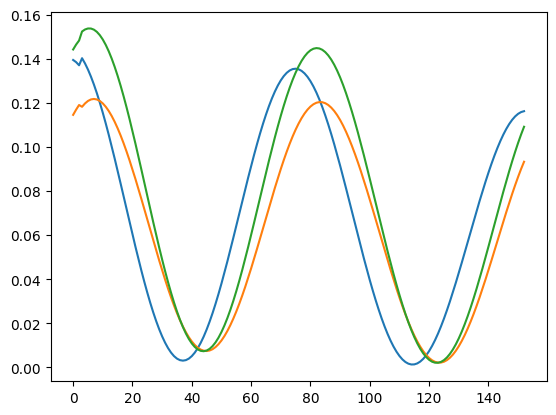

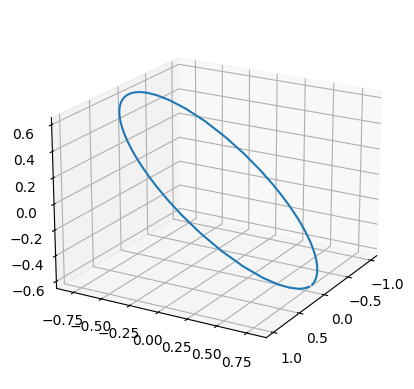

In [ ]:
right_mean, right_disp = stats_periodic(right_ssa.T, 153)

plt.plot(right_disp)
plots([right_mean], [None], 300, 20, 30)

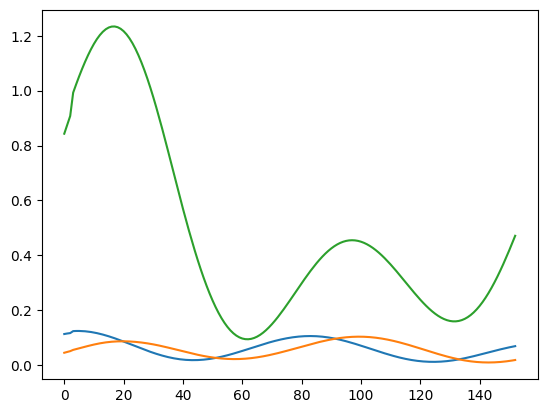

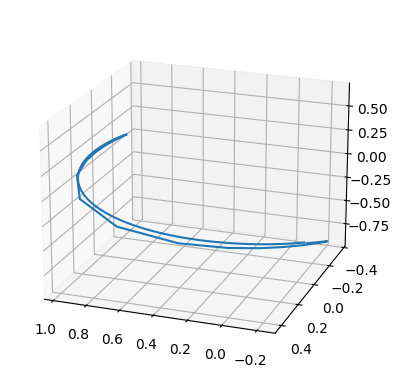

In [ ]:
left_mean, left_disp = stats_periodic(left_ssa.T, 153)

plt.plot(left_disp)
plots([left_mean], [None], 300, 20, 110)

In [ ]:
left_ssa = SSA(left_h_s[..., 0], 200, 4, 2)

plt.plot(left_ssa[0])
plt.plot(left_ssa[1])
plt.plot(left_ssa[2])

plt.plot(left_ssa[:, 0], left_ssa[:, 1])
plt.show()
plots([left_ssa[:, :3]],[None])

In [ ]:
right_ssa = SSA(right_h_s[:], 200, 4, 2)

# plt.plot(right_ssa[0])
# plt.plot(left_ssa[1])
# plt.plot(left_ssa[2])

plt.plot(right_ssa[:, 0], right_ssa[:, 1])
plt.show()
plots([left_ssa[:, :3]],[None])

In [ ]:
import numpy as np
tmp = np.vstack([left_h_s[i: i + 300, 0] for i in range(left_h_s.shape[0] - 300)]).T
print(tmp.shape)

P, D, Q = np.linalg.svd(tmp)
dim = 3
print(P.shape, D.shape, Q.shape)
hid = P[:, : dim] @ np.diag(D[:dim])
val = P[:, : dim] @ np.diag(D[:dim]) @ Q[:dim]
print(D[:10])

(300, 1999)
(300, 300) (300,) (1999, 1999)
[460.76022  451.63702  103.26561  101.41547   66.24137   58.517265
  35.224308  34.9423    31.284904  30.332079]


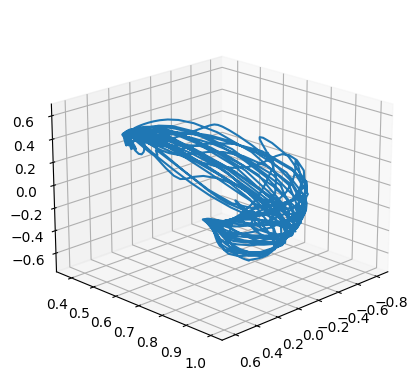

In [ ]:
from sklearn.preprocessing import normalize
to = 3300
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tmp = normalize(left_h_s, axis = 1)
ax.plot(tmp[:, 0][:to], tmp[:, 1][:to], tmp[:, 2][:to], label='parametric curve')
ax.view_init(20, 45)

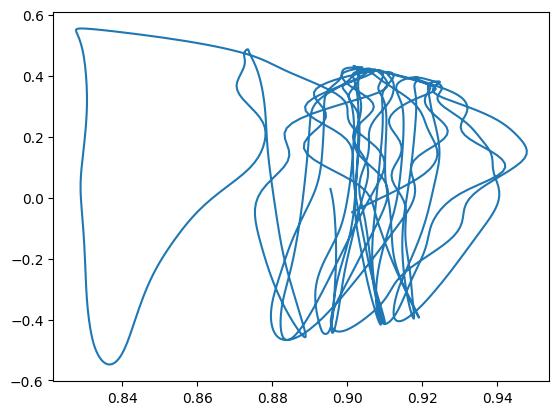

In [ ]:
plt.plot(tmp[..., 0][:to],tmp[..., 1][:to])

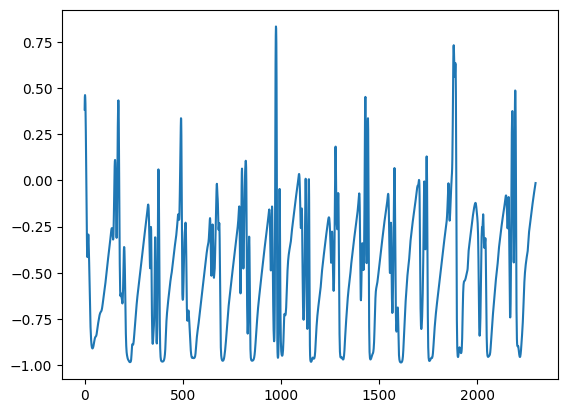

In [ ]:
plt.plot(left_h_s)

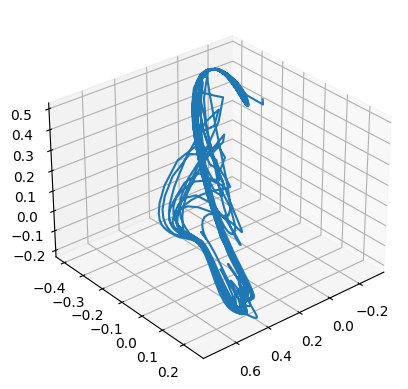

In [ ]:
from sklearn.preprocessing import normalize


tmp = normalize(left_h_s, axis = 1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(tmp[..., 0][:to], tmp[..., 1][:to], tmp[..., 2][:to], label='parametric curve')
ax.view_init(30, 50)

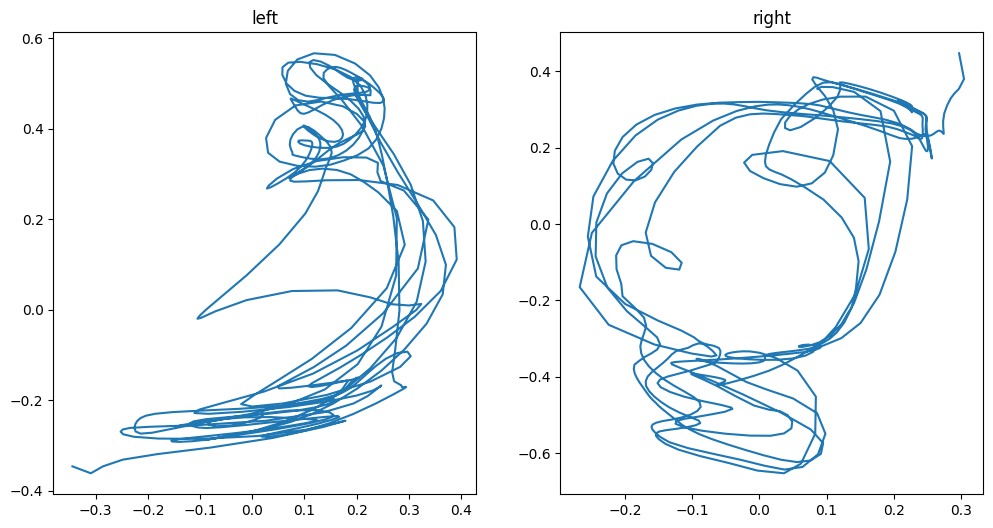

In [ ]:
# 50 hz
to = 600
fig, axs = plt.subplots(1, 2, figsize = (12, 6))


tmp = normalize(left_h_s, axis = 1)
axs[0].plot(tmp[..., 0][:to],tmp[..., 1][:to])
axs[0].set_title("left")

tmp = normalize(right_h_s, axis = 1)
axs[1].plot(tmp[..., 0][:to],tmp[..., 1][:to])
axs[1].set_title("right")

# axs[2].plot(right_h_s[..., 1][:to],left_h_s[..., 1][:to])
# axs[2].set_title("diff")
plt.show()

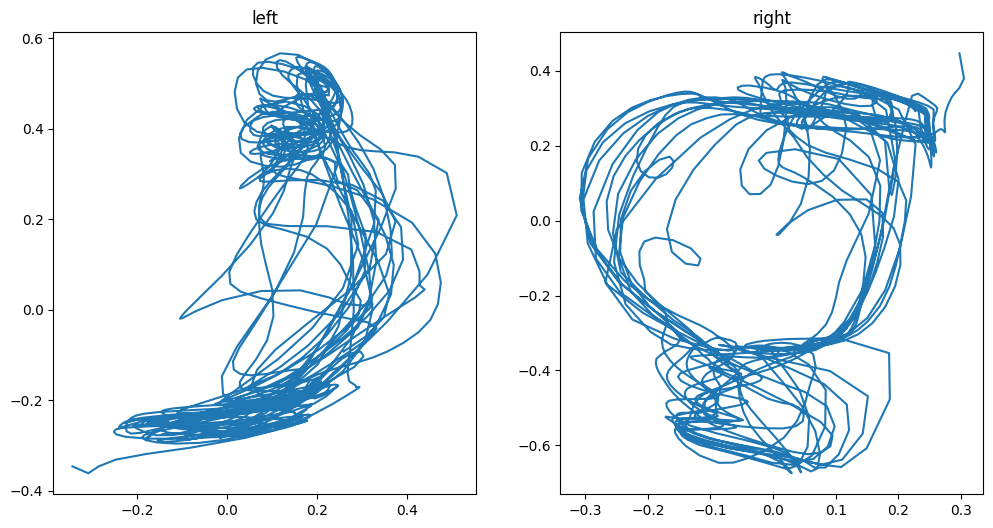

In [ ]:
# 200 hz
to = 2000
fig, axs = plt.subplots(1, 2, figsize = (12, 6))


tmp = normalize(left_h_s, axis = 1)
axs[0].plot(tmp[..., 0][:to],tmp[..., 1][:to])
axs[0].set_title("left")

tmp = normalize(right_h_s, axis = 1)
axs[1].plot(tmp[..., 0][:to],tmp[..., 1][:to])
axs[1].set_title("right")

# axs[2].plot(right_h_s[..., 1][:to],left_h_s[..., 1][:to])
# axs[2].set_title("diff")
plt.show()

In [ ]:
right_h_s.shape

(2249, 2)

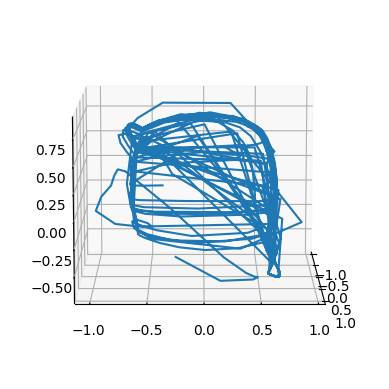

In [ ]:
from sklearn.preprocessing import normalize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tmp = normalize(left_h_s, axis = 1)
ax.plot(tmp[..., 0][:to], tmp[..., 1][:to], tmp[..., 2][:to], label='parametric curve')
ax.view_init(10, 0)

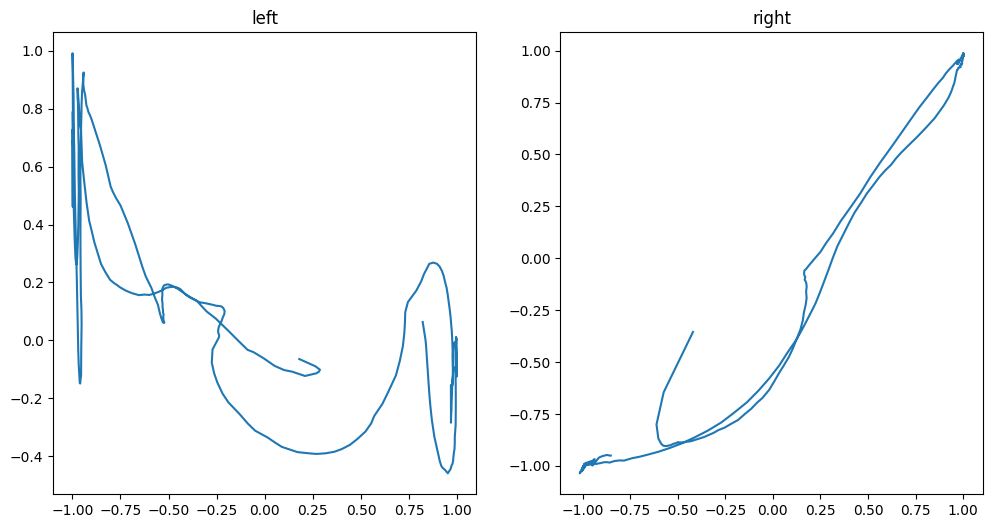

In [ ]:
to = 500
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
axs[0].plot(left_h_s[..., 0][:to],left_h_s[..., 1][:to])
axs[0].set_title("left")

axs[1].plot(right_h_s[..., 0][:to],right_h_s[..., 1][:to])
axs[1].set_title("right")

# axs[2].plot(right_h_s[..., 1][:to],left_h_s[..., 1][:to])
# axs[2].set_title("diff")
plt.show()

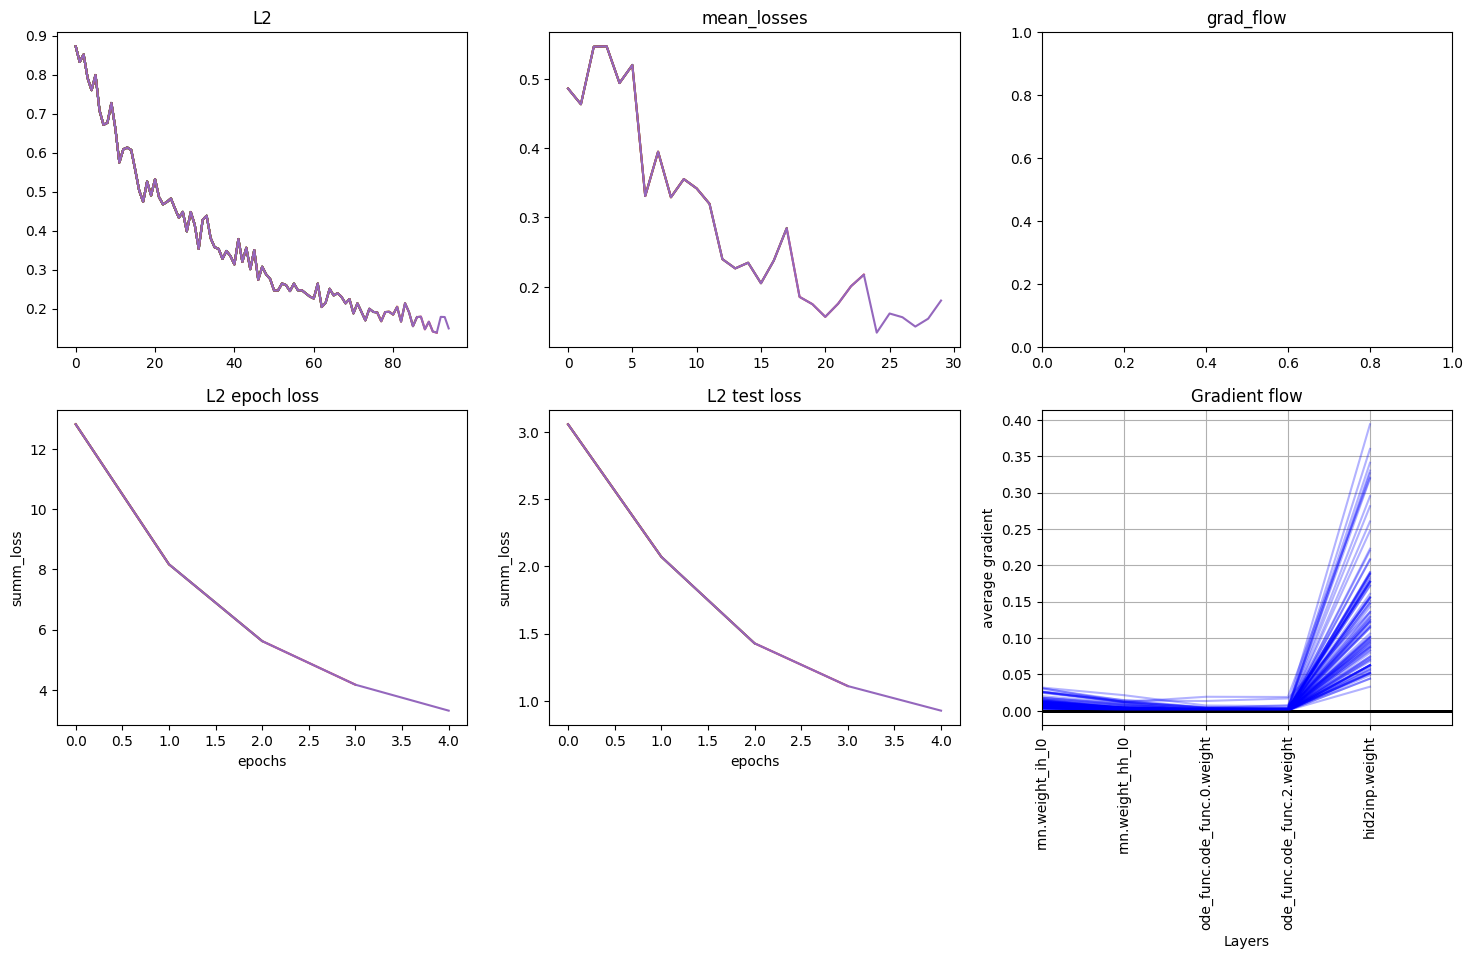

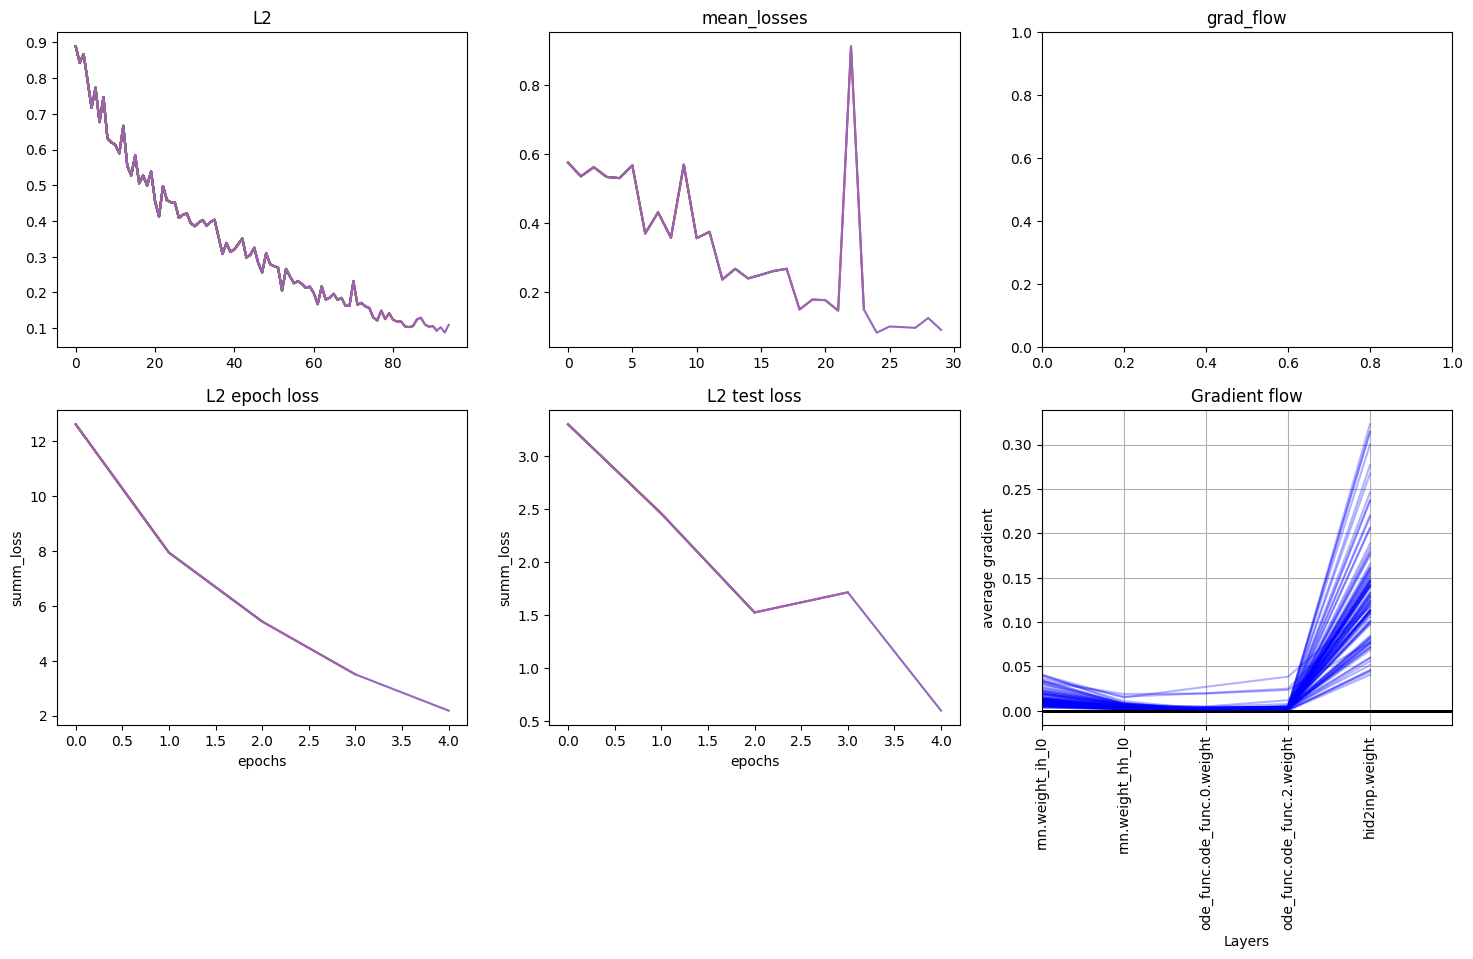

(ODE_RNN(
   (rnn): GRU(3, 2)
   (ode_func): ODE_func(
     (ode_func): Sequential(
       (0): Linear(in_features=2, out_features=2, bias=True)
       (1): ELU(alpha=1.0, inplace=True)
       (2): Linear(in_features=2, out_features=2, bias=True)
     )
   )
   (ode): NeuralODE(
     (func): ODE_func(
       (ode_func): Sequential(
         (0): Linear(in_features=2, out_features=2, bias=True)
         (1): ELU(alpha=1.0, inplace=True)
         (2): Linear(in_features=2, out_features=2, bias=True)
       )
     )
   )
   (hid2inp): Linear(in_features=2, out_features=3, bias=True)
   (loss_function): MSELoss()
 ),
 ODE_RNN(
   (rnn): GRU(3, 2)
   (ode_func): ODE_func(
     (ode_func): Sequential(
       (0): Linear(in_features=2, out_features=2, bias=True)
       (1): ELU(alpha=1.0, inplace=True)
       (2): Linear(in_features=2, out_features=2, bias=True)
     )
   )
   (ode): NeuralODE(
     (func): ODE_func(
       (ode_func): Sequential(
         (0): Linear(in_features=2, out_featu

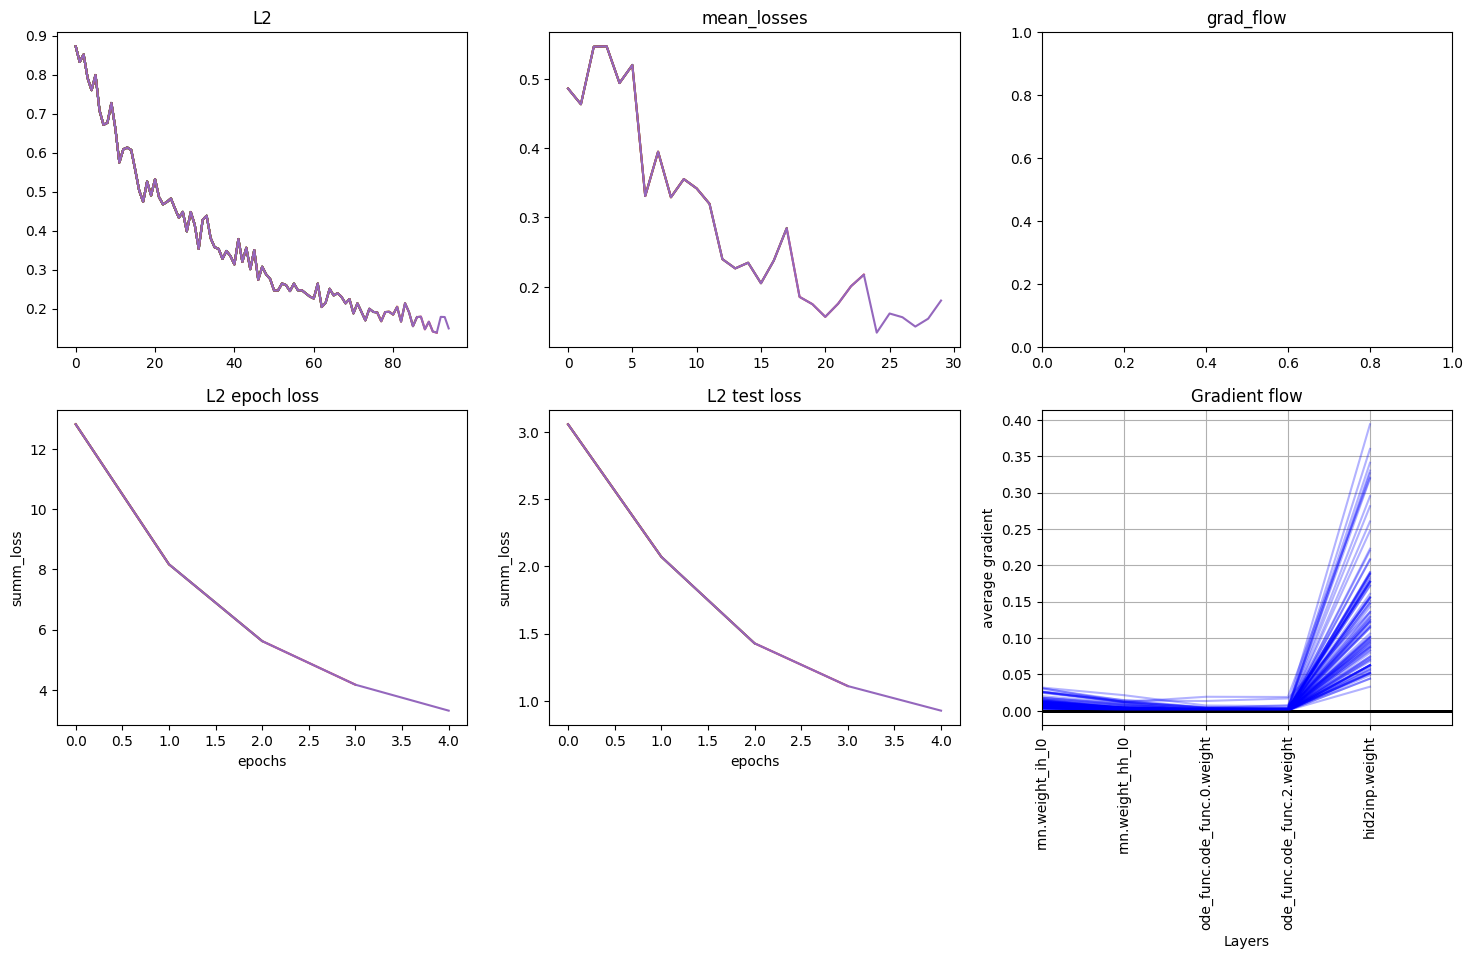

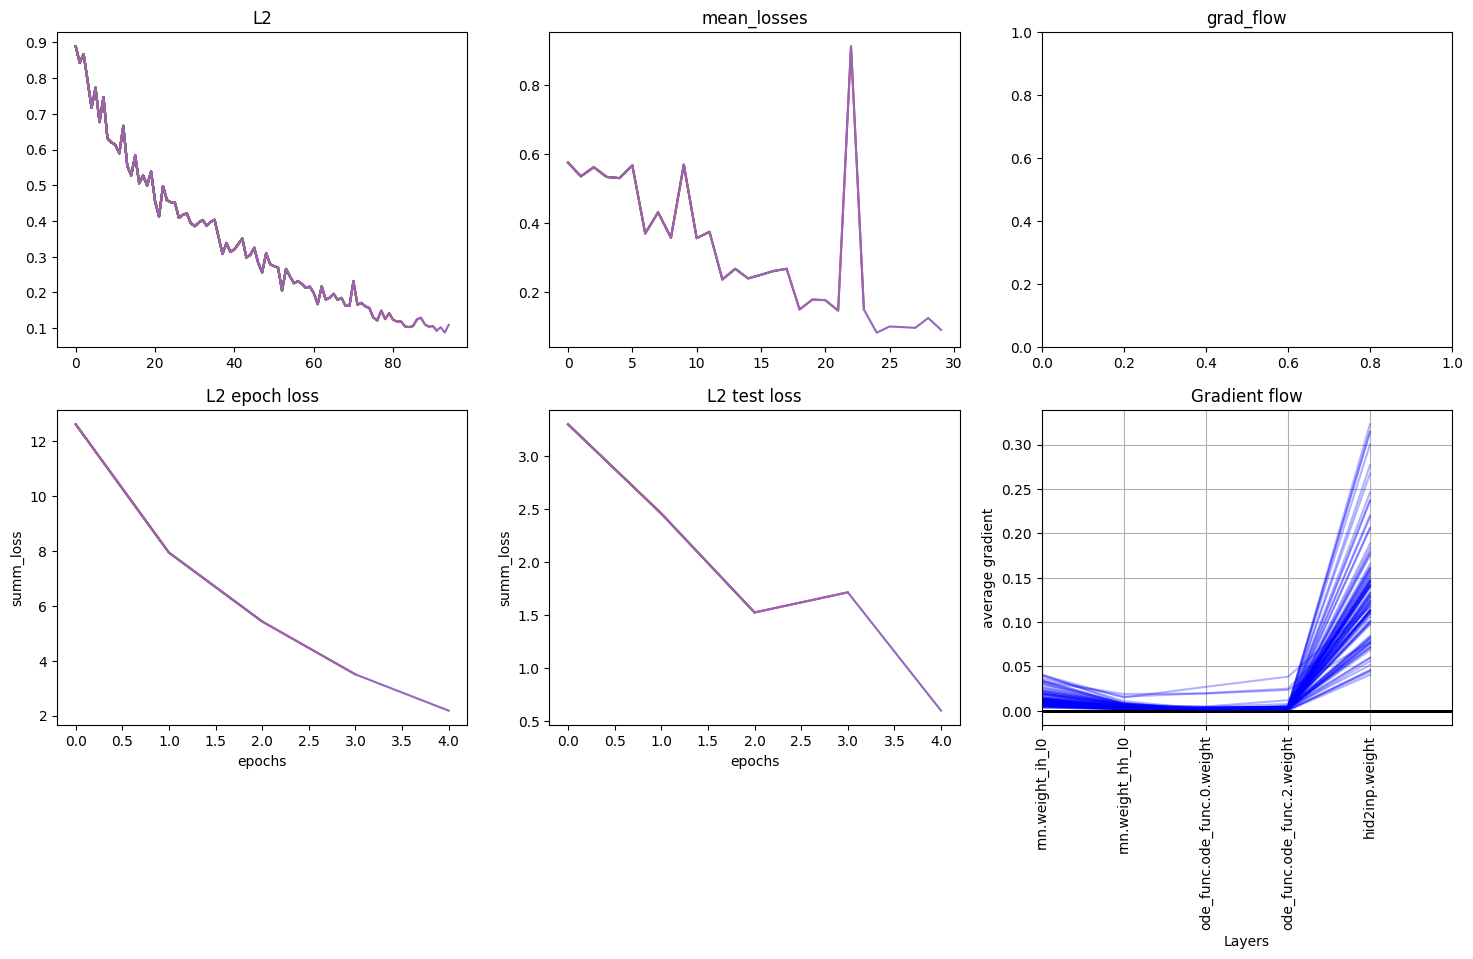

In [ ]:
train_on_pair((left_train, left_test), (right_train, right_test), net, net, epochs)

(1800, 3)


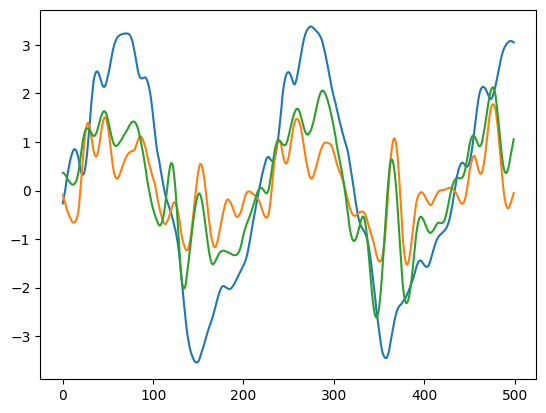

In [ ]:
tmp = np.array(left.iloc[:, 2:].values)[700: 2500]
plt.plot(tmp[:500])
print(tmp.shape)
tmp = np.concatenate([tmp[i: i + 300][None, :] for i in range(tmp.shape[0] - 300)], axis = 0)

(1800, 3)


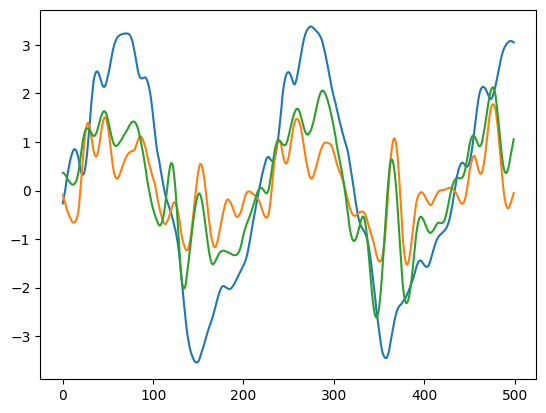

In [ ]:
import torch.nn as nn

tmp = np.array(left.iloc[:, 2:].values)[700: 2500]
plt.plot(tmp[:500])
print(tmp.shape)
tmp = np.concatenate([tmp[i: i + 400][None, :] for i in range(tmp.shape[0] - 400)], axis = 0)

model = nn.Sequential(
    nn.Conv1d(3, 1, 3),
    # nn.ReLU(),
    # nn.Conv1d(2, 1, 3)
    )

rez =model(torch.tensor(tmp).permute(0, 2, 1).float()).squeeze()

In [ ]:
D[:14]

array([145.41153 , 134.20177 ,  61.712254,  61.234726,  58.37302 ,
        57.22846 ,  48.70563 ,  47.63005 ,  45.976852,  45.200806,
        44.079224,  36.78627 ,  36.608253,  31.658453], dtype=float32)

(1400, 1400) (398,) (398, 398)


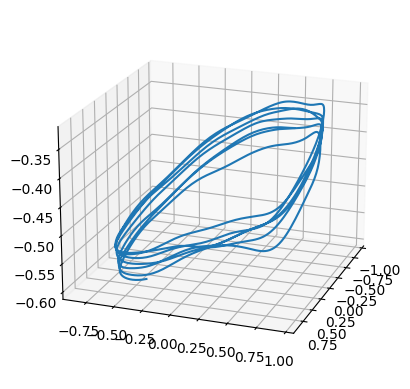

In [ ]:
P, D, Q = np.linalg.svd(rez.detach().numpy())
print(P.shape, D.shape, Q.shape)
hid = P[:, : dim] @ np.diag(D[:dim])
val = P[:, : dim] @ np.diag(D[:dim]) @ Q[:dim]
hid.shape  


from sklearn.preprocessing import normalize
to = 1400
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tmp = normalize(hid, axis = 1)
ax.plot(tmp[:, 0][:to], tmp[:, 1][:to], tmp[:, 2][:to], label='parametric curve')
ax.view_init(20, 20)

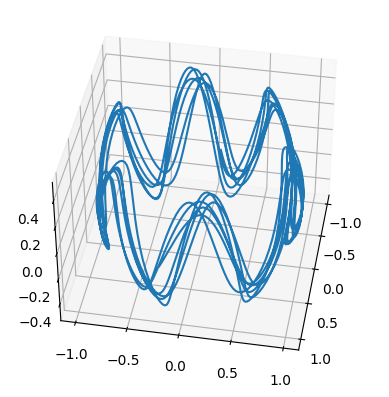

In [ ]:
to = 1400
fig = plt.figure()
tmp = normalize(hid, axis = 1)
ax = fig.add_subplot(111, projection='3d')
ax.plot(tmp[:, 0][:to], tmp[:, 1][:to], tmp[:, 2][:to], label='parametric curve')
ax.view_init(40, 10)

In [ ]:
rez.shape

torch.Size([1400, 2])

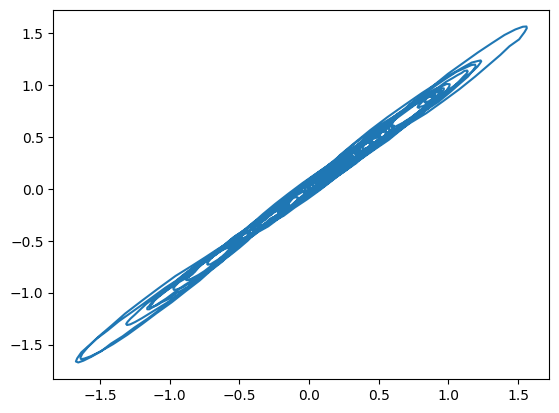

In [ ]:
tmp = rez.detach().numpy()
plt.plot(tmp[:,0],tmp[:,1])